<a href="https://colab.research.google.com/github/MHC-FA24-CS341CV/beyond-the-pixels-emerging-computer-vision-research-topics-fa24/blob/main/VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on the Visual Question Answering (VQA) tutorial from Hugging Face (https://huggingface.co/docs/transformers/v4.46.2/tasks/visual_question_answering). Instead of the ViLT model and dataset used in the tutorial, it utilizes the BLIP-2 model and the official VQA v2.0 dataset, available at https://visualqa.org/download.html. Please refer to the README.txt for more detailed instructions on downloading and setting up the required dataset to run this notebook.

Also, for optimal performance, it is encouraged to run this notebook in a GPU environment, such as with a T4 GPU.

# Install the necessary library
This cel installs the Hugging Face transformers library, which provides the pre-trained models for various NLP and vision tasks.

In [1]:
!pip install -q transformers

# Set Up
The cell below loads the BLIP-2 model and its processor. The model is moved to GPU if available to optimize performance during inference. This step should take a while.

In [2]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

# Load the processor and model for BLIP-2 (2.7B version)
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

# Load the image and corresponding question/annotation data
This part extracts a specific image for use in this demo, loads question and annotation data from JSON files, and retrieves the question and answer choices corresponding to the image we'll use throughout this notebook.

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip the specific cat image from val2014.zip (change the zip file path accordingly)
!unzip -j /content/drive/MyDrive/Program4_dataset_14_VQA/val2014.zip 'val2014/COCO_val2014_000000000599.jpg' -d /content/val2014

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Program4_dataset_14_VQA/val2014.zip
 extracting: /content/val2014/COCO_val2014_000000000599.jpg  


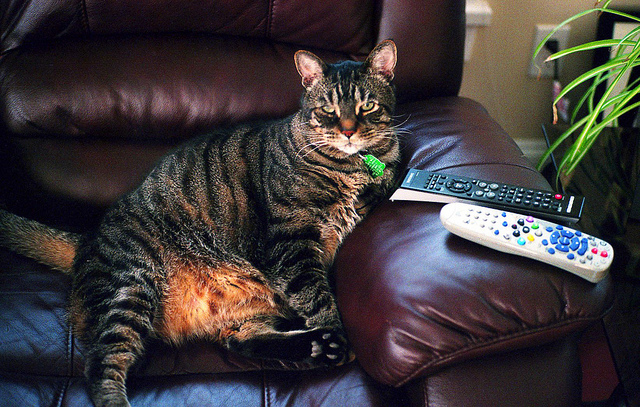

In [4]:
from PIL import Image
from IPython.display import display

# Use the specific cat image ID
image_id = "000000000599"
image_path = f'/content/val2014/COCO_val2014_{image_id}.jpg'

# Open and display the cat image we're going to use
image = Image.open(image_path)
display(image)

In [5]:
import json

# Load JSON files directly from Google Drive (change the paths accordingly)
with open('/content/drive/MyDrive/Program4_dataset_14_VQA/v2_OpenEnded_mscoco_val2014_questions.json', 'r') as f:
    questions = json.load(f)['questions']

with open('/content/drive/MyDrive/Program4_dataset_14_VQA/v2_mscoco_val2014_annotations.json', 'r') as f:
    annotations = json.load(f)['annotations']

target_image_id = 599 # Specify the target image ID for the cat image

# Find the question and annotation matching the cat image ID
matching_questions = [q for q in questions if q['image_id'] == target_image_id]
matching_annotations = [a for a in annotations if a['image_id'] == target_image_id]

# This part shows the question associated with the cat image, along with multiple answer choices provided by human annotators
# These answer choices act as reference points, allowing us to later compare and assess the model's response accuracy in the VQA task
if matching_questions and matching_annotations:
    selected_question = matching_questions[0]
    selected_annotation = matching_annotations[0]
    print("Question:", selected_question['question'])
    print("Answer choices:", [ans['answer'] for ans in selected_annotation['answers']])
else:
    print("No matching question found for the specified image.")

Question: How many cat toes are visible?
Answer choices: ['3', '0', '4', '1', 'yes', '4', '4', '1', '3', '10']


# Run Inference and Compare with Human Annotations
This section passes the question "How many cat toes are visible?" to the model and displays the model’s answer. If the model’s answer matches any of the human-provided answer choices (from the previous cell output), we can consider the model to be working correctly. Additionally, if the model provides a reasonable answer even if it doesn't exactly match the answer choices, it may still be deemed correct. Try running the following cell multiple times to observe any variations in the model's answers :)

In [16]:
# Prepare the question text
question = selected_question['question'] + "\nAnswer:"

# Preprocess the image and question for the model
inputs = processor(images=image, text=question, return_tensors="pt").to(device)

# Run inference to generate an answer
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=20, do_sample=True, temperature=0.8, top_p=0.9)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

# Display the question and the model's answer
print("Question: ", question + " " + generated_text)

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Question:  How many cat toes are visible?
Answer: 4


# Interactive VQA Process with Clarification Feature
In this part, the user can experience an interactive Visual Question Answering (VQA) process with a clarification feature. The user can ask questions about the cat image, and if the question is considered ambiguous, a clarification prompt will appear. Once clarified, the VQA model will generate an answer based on the final question.

**Step1: Define ambiguous terms/context keywords and the clarification question function**

The cell below defines a list of ambiguous terms and contextual keywords. If a user’s question contains ambiguous terms without sufficient context, the function will prompt the user for clarification to ensure the question is clear.

In [7]:
ambiguous_terms = ["it", "this", "that", "thing", "object", "there"]
context_keywords = ["on", "near", "by", "in", "with", "next to", "in front of", "beside", "behind"]

def detect_ambiguity_and_generate_clarification(question):
    if any(term in question.lower() for term in ambiguous_terms):
        if not any(keyword in question.lower() for keyword in context_keywords):
            # Prompt for clarification if ambiguous terms are present without any contextual keywords
            return "Could you provide more details? If you're referring to something specific, please include additional context, like 'on the sofa' or 'next to the cat.'"
    return None

**Step2: Define function to get user question and prompt clarification if needed**

The cell below defines a function that prompts the user to type a question about the cat image and checks for ambiguity. If the question is ambiguous, the user will be prompted for clarification until a clear question is provided.

In [18]:
def get_clarified_question():
    # Get user's initial question
    question = input("Ask a question about the cat image: ")

    # Check for ambiguity
    clarification = detect_ambiguity_and_generate_clarification(question)

    while clarification:
        # Display clarification question and get user's clarified question
        print(f"Clarification needed: {clarification}")
        question = input("Could you rephrase or specify your question more clearly: ")

        # Re-check if the clarified question is still ambiguous
        clarification = detect_ambiguity_and_generate_clarification(question)

    return question

**Step3: Define function to pass the clarified question to the VQA model and generate an answer**

The following cell defines a function that takes the clarified question and processes it with the VQA model to generate an answer about the cat image.

In [9]:
def process_vqa_with_model(image, question):
    formatted_question = f"Question: {question} Answer:"
    inputs = processor(images=image, text=formatted_question, return_tensors="pt").to(device, torch.float16)

    # Run inference to generate an answer
    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=20)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    # Display the model's answer
    print("Model's answer:", generated_text)

**Step4: Run the interactive VQA process**

The user can test the interactive VQA process by running the following cell. The user will be prompted to ask a question about the image, which will be clarified if needed, and then the VQA model will generate an answer based on the clarified question.

In [19]:
# Test the interactive VQA process with clarification feature
question = get_clarified_question()
process_vqa_with_model(image, question)

Ask a question about the cat image: Is it a cat?
Clarification needed: Could you provide more details? If you're referring to something specific, please include additional context, like 'on the sofa' or 'next to the cat.'
Could you rephrase or specify your question more clearly: Is it on the sofa a cat? 


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Model's answer: Yes
